<a href="https://colab.research.google.com/github/Tanisha-agr/my-website/blob/main/yolov7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openvino

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 14.5 MB/s eta 0:00:00


In [ ]:
!pip install 'openvino-dev[tensorflow2,mxnet,caffe]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 5.8 MB/s eta 0:00:00
  Created wheel for jstyleson: filename=jstyleson-0.0.2-py3-none-any.whl size=2384 sha256=1ab28ddb9bd13fc192727fdfcce252d216ba21e251372b409eb1824a7640282b
  Stored in directory: /root/.cache/pip/wheels/12/51/c6/a1e751db88203e11c6d9ffe4683ca3d8c14b1479639bec1006
Successfully built jstyleson
  Attempting uninstall: fastjsonschema
    Found existing installation: fastjsonschema 2.17.1
    Uninstalling fastjsonschema-2.17.1:
      Successfully uninstalled fastjsonschema-2.17.1
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uni

# Notebook_utils

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import os
import threading
import time
import urllib.parse
from os import PathLike
from pathlib import Path
from typing import List, NamedTuple, Optional, Tuple

import numpy as np
from openvino.runtime import Core, get_version
from IPython.display import HTML, Image, display


# ## Files
#
# Load an image, download a file, download an IR model, and create a progress bar to show download progress.

# In[ ]:


def load_image(path: str) -> np.ndarray:
    """
    Loads an image from `path` and returns it as BGR numpy array. `path`
    should point to an image file, either a local filename or a url. The image is
    not stored to the filesystem. Use the `download_file` function to download and
    store an image.

    :param path: Local path name or URL to image.
    :return: image as BGR numpy array
    """
    import cv2
    import requests

    if path.startswith("http"):
        # Set User-Agent to Mozilla because some websites block
        # requests with User-Agent Python
        response = requests.get(path, headers={"User-Agent": "Mozilla/5.0"})
        array = np.asarray(bytearray(response.content), dtype="uint8")
        image = cv2.imdecode(array, -1)  # Loads the image as BGR
    else:
        image = cv2.imread(path)
    return image


def download_file(
    url: PathLike,
    filename: PathLike = None,
    directory: PathLike = None,
    show_progress: bool = True,
    silent: bool = False,
    timeout: int = 10,
) -> PathLike:
    """
    Download a file from a url and save it to the local filesystem. The file is saved to the
    current directory by default, or to `directory` if specified. If a filename is not given,
    the filename of the URL will be used.

    :param url: URL that points to the file to download
    :param filename: Name of the local file to save. Should point to the name of the file only,
                     not the full path. If None the filename from the url will be used
    :param directory: Directory to save the file to. Will be created if it doesn't exist
                      If None the file will be saved to the current working directory
    :param show_progress: If True, show an TQDM ProgressBar
    :param silent: If True, do not print a message if the file already exists
    :param timeout: Number of seconds before cancelling the connection attempt
    :return: path to downloaded file
    """
    from tqdm.notebook import tqdm_notebook
    import requests

    filename = filename or Path(urllib.parse.urlparse(url).path).name
    chunk_size = 16384  # make chunks bigger so that not too many updates are triggered for Jupyter front-end

    filename = Path(filename)
    if len(filename.parts) > 1:
        raise ValueError(
            "`filename` should refer to the name of the file, excluding the directory. "
            "Use the `directory` parameter to specify a target directory for the downloaded file."
        )

    # create the directory if it does not exist, and add the directory to the filename
    if directory is not None:
        directory = Path(directory)
        directory.mkdir(parents=True, exist_ok=True)
        filename = directory / Path(filename)

    try:
        response = requests.get(url=url,
                                headers={"User-agent": "Mozilla/5.0"},
                                stream=True)
        response.raise_for_status()
    except requests.exceptions.HTTPError as error:  # For error associated with not-200 codes. Will output something like: "404 Client Error: Not Found for url: {url}"
        raise Exception(error) from None
    except requests.exceptions.Timeout:
        raise Exception(
                "Connection timed out. If you access the internet through a proxy server, please "
                "make sure the proxy is set in the shell from where you launched Jupyter."
        ) from None
    except requests.exceptions.RequestException as error:
        raise Exception(f"File downloading failed with error: {error}") from None

    # download the file if it does not exist, or if it exists with an incorrect file size
    filesize = int(response.headers.get("Content-length", 0))
    if not filename.exists() or (os.stat(filename).st_size != filesize):

        with tqdm_notebook(
            total=filesize,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
            desc=str(filename),
            disable=not show_progress,
        ) as progress_bar:

            with open(filename, "wb") as file_object:
                for chunk in response.iter_content(chunk_size):
                    file_object.write(chunk)
                    progress_bar.update(len(chunk))
                    progress_bar.refresh()
    else:
        if not silent:
            print(f"'{filename}' already exists.")

    response.close()

    return filename.resolve()


def download_ir_model(model_xml_url: str, destination_folder: PathLike = None) -> PathLike:
    """
    Download IR model from `model_xml_url`. Downloads model xml and bin file; the weights file is
    assumed to exist at the same location and name as model_xml_url with a ".bin" extension.

    :param model_xml_url: URL to model xml file to download
    :param destination_folder: Directory where downloaded model xml and bin are saved. If None, model
                               files are saved to the current directory
    :return: path to downloaded xml model file
    """
    model_bin_url = model_xml_url[:-4] + ".bin"
    model_xml_path = download_file(model_xml_url, directory=destination_folder, show_progress=False)
    download_file(model_bin_url, directory=destination_folder)
    return model_xml_path


# ## Images

# ### Convert Pixel Data
#
# Normalize image pixel values between 0 and 1, and convert images to RGB and BGR.

# In[ ]:


def normalize_minmax(data):
    """
    Normalizes the values in `data` between 0 and 1
    """
    if data.max() == data.min():
        raise ValueError(
            "Normalization is not possible because all elements of"
            f"`data` have the same value: {data.max()}."
        )
    return (data - data.min()) / (data.max() - data.min())


def to_rgb(image_data: np.ndarray) -> np.ndarray:
    """
    Convert image_data from BGR to RGB
    """
    import cv2
    return cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)


def to_bgr(image_data: np.ndarray) -> np.ndarray:
    """
    Convert image_data from RGB to BGR
    """
    import cv2
    return cv2.cvtColor(image_data, cv2.COLOR_RGB2BGR)


# ## Videos

# ### Video Player
#
# Custom video player to fulfill FPS requirements. You can set target FPS and output size, flip the video horizontally or skip first N frames.

# In[ ]:


class VideoPlayer:
    """
    Custom video player to fulfill FPS requirements. You can set target FPS and output size,
    flip the video horizontally or skip first N frames.

    :param source: Video source. It could be either camera device or video file.
    :param size: Output frame size.
    :param flip: Flip source horizontally.
    :param fps: Target FPS.
    :param skip_first_frames: Skip first N frames.
    """

    def __init__(self, source, size=None, flip=False, fps=None, skip_first_frames=0):
        import cv2

        self.cv2 = cv2  # This is done to access the package in class methods
        self.__cap = cv2.VideoCapture(source)
        if not self.__cap.isOpened():
            raise RuntimeError(
                f"Cannot open {'camera' if isinstance(source, int) else ''} {source}"
            )
        # skip first N frames
        self.__cap.set(cv2.CAP_PROP_POS_FRAMES, skip_first_frames)
        # fps of input file
        self.__input_fps = self.__cap.get(cv2.CAP_PROP_FPS)
        if self.__input_fps <= 0:
            self.__input_fps = 60
        # target fps given by user
        self.__output_fps = fps if fps is not None else self.__input_fps
        self.__flip = flip
        self.__size = None
        self.__interpolation = None
        if size is not None:
            self.__size = size
            # AREA better for shrinking, LINEAR better for enlarging
            self.__interpolation = (
                cv2.INTER_AREA
                if size[0] < self.__cap.get(cv2.CAP_PROP_FRAME_WIDTH)
                else cv2.INTER_LINEAR
            )
        # first frame
        _, self.__frame = self.__cap.read()
        self.__lock = threading.Lock()
        self.__thread = None
        self.__stop = False

    """
    Start playing.
    """

    def start(self):
        self.__stop = False
        self.__thread = threading.Thread(target=self.__run, daemon=True)
        self.__thread.start()

    """
    Stop playing and release resources.
    """

    def stop(self):
        self.__stop = True
        if self.__thread is not None:
            self.__thread.join()
        self.__cap.release()

    def __run(self):
        prev_time = 0
        while not self.__stop:
            t1 = time.time()
            ret, frame = self.__cap.read()
            if not ret:
                break

            # fulfill target fps
            if 1 / self.__output_fps < time.time() - prev_time:
                prev_time = time.time()
                # replace by current frame
                with self.__lock:
                    self.__frame = frame

            t2 = time.time()
            # time to wait [s] to fulfill input fps
            wait_time = 1 / self.__input_fps - (t2 - t1)
            # wait until
            time.sleep(max(0, wait_time))

        self.__frame = None

    """
    Get current frame.
    """

    def next(self):
        import cv2

        with self.__lock:
            if self.__frame is None:
                return None
            # need to copy frame, because can be cached and reused if fps is low
            frame = self.__frame.copy()
        if self.__size is not None:
            frame = self.cv2.resize(frame, self.__size, interpolation=self.__interpolation)
        if self.__flip:
            frame = self.cv2.flip(frame, 1)
        return frame


# ## Visualization

# ### Segmentation
#
# Define a SegmentationMap NamedTuple that keeps the labels and colormap for a segmentation project/dataset. Create CityScapesSegmentation and BinarySegmentation SegmentationMaps. Create a function to convert a segmentation map to an RGB image with a colormap, and to show the segmentation result as an overlay over the original image.

# In[ ]:


class Label(NamedTuple):
    index: int
    color: Tuple
    name: Optional[str] = None


# In[ ]:


class SegmentationMap(NamedTuple):
    labels: List

    def get_colormap(self):
        return np.array([label.color for label in self.labels])

    def get_labels(self):
        labelnames = [label.name for label in self.labels]
        if any(labelnames):
            return labelnames
        else:
            return None


# In[ ]:


cityscape_labels = [
    Label(index=0, color=(128, 64, 128), name="road"),
    Label(index=1, color=(244, 35, 232), name="sidewalk"),
    Label(index=2, color=(70, 70, 70), name="building"),
    Label(index=3, color=(102, 102, 156), name="wall"),
    Label(index=4, color=(190, 153, 153), name="fence"),
    Label(index=5, color=(153, 153, 153), name="pole"),
    Label(index=6, color=(250, 170, 30), name="traffic light"),
    Label(index=7, color=(220, 220, 0), name="traffic sign"),
    Label(index=8, color=(107, 142, 35), name="vegetation"),
    Label(index=9, color=(152, 251, 152), name="terrain"),
    Label(index=10, color=(70, 130, 180), name="sky"),
    Label(index=11, color=(220, 20, 60), name="person"),
    Label(index=12, color=(255, 0, 0), name="rider"),
    Label(index=13, color=(0, 0, 142), name="car"),
    Label(index=14, color=(0, 0, 70), name="truck"),
    Label(index=15, color=(0, 60, 100), name="bus"),
    Label(index=16, color=(0, 80, 100), name="train"),
    Label(index=17, color=(0, 0, 230), name="motorcycle"),
    Label(index=18, color=(119, 11, 32), name="bicycle"),
    Label(index=19, color=(255, 255, 255), name="background"),
]

CityScapesSegmentation = SegmentationMap(cityscape_labels)

binary_labels = [
    Label(index=0, color=(255, 255, 255), name="background"),
    Label(index=1, color=(0, 0, 0), name="foreground"),
]

BinarySegmentation = SegmentationMap(binary_labels)


# In[ ]:


def segmentation_map_to_image(
    result: np.ndarray, colormap: np.ndarray, remove_holes: bool = False
) -> np.ndarray:
    """
    Convert network result of floating point numbers to an RGB image with
    integer values from 0-255 by applying a colormap.

    :param result: A single network result after converting to pixel values in H,W or 1,H,W shape.
    :param colormap: A numpy array of shape (num_classes, 3) with an RGB value per class.
    :param remove_holes: If True, remove holes in the segmentation result.
    :return: An RGB image where each pixel is an int8 value according to colormap.
    """
    import cv2
    if len(result.shape) != 2 and result.shape[0] != 1:
        raise ValueError(
            f"Expected result with shape (H,W) or (1,H,W), got result with shape {result.shape}"
        )

    if len(np.unique(result)) > colormap.shape[0]:
        raise ValueError(
            f"Expected max {colormap[0]} classes in result, got {len(np.unique(result))} "
            "different output values. Please make sure to convert the network output to "
            "pixel values before calling this function."
        )
    elif result.shape[0] == 1:
        result = result.squeeze(0)

    result = result.astype(np.uint8)

    contour_mode = cv2.RETR_EXTERNAL if remove_holes else cv2.RETR_TREE
    mask = np.zeros((result.shape[0], result.shape[1], 3), dtype=np.uint8)
    for label_index, color in enumerate(colormap):
        label_index_map = result == label_index
        label_index_map = label_index_map.astype(np.uint8) * 255
        contours, hierarchies = cv2.findContours(
            label_index_map, contour_mode, cv2.CHAIN_APPROX_SIMPLE
        )
        cv2.drawContours(
            mask,
            contours,
            contourIdx=-1,
            color=color.tolist(),
            thickness=cv2.FILLED,
        )

    return mask


def segmentation_map_to_overlay(image, result, alpha, colormap, remove_holes=False) -> np.ndarray:
    """
    Returns a new image where a segmentation mask (created with colormap) is overlayed on
    the source image.

    :param image: Source image.
    :param result: A single network result after converting to pixel values in H,W or 1,H,W shape.
    :param alpha: Alpha transparency value for the overlay image.
    :param colormap: A numpy array of shape (num_classes, 3) with an RGB value per class.
    :param remove_holes: If True, remove holes in the segmentation result.
    :return: An RGP image with segmentation mask overlayed on the source image.
    """
    import cv2
    if len(image.shape) == 2:
        image = np.repeat(np.expand_dims(image, -1), 3, 2)
    mask = segmentation_map_to_image(result, colormap, remove_holes)
    image_height, image_width = image.shape[:2]
    mask = cv2.resize(src=mask, dsize=(image_width, image_height))
    return cv2.addWeighted(mask, alpha, image, 1 - alpha, 0)


# ### Network Results
#
# Show network result image, optionally together with the source image and a legend with labels.

# In[ ]:


def viz_result_image(
    result_image: np.ndarray,
    source_image: np.ndarray = None,
    source_title: str = None,
    result_title: str = None,
    labels: List[Label] = None,
    resize: bool = False,
    bgr_to_rgb: bool = False,
    hide_axes: bool = False,
):
    """
    Show result image, optionally together with source images, and a legend with labels.

    :param result_image: Numpy array of RGB result image.
    :param source_image: Numpy array of source image. If provided this image will be shown
                         next to the result image. source_image is expected to be in RGB format.
                         Set bgr_to_rgb to True if source_image is in BGR format.
    :param source_title: Title to display for the source image.
    :param result_title: Title to display for the result image.
    :param labels: List of labels. If provided, a legend will be shown with the given labels.
    :param resize: If true, resize the result image to the same shape as the source image.
    :param bgr_to_rgb: If true, convert the source image from BGR to RGB. Use this option if
                       source_image is a BGR image.
    :param hide_axes: If true, do not show matplotlib axes.
    :return: Matplotlib figure with result image
    """
    import cv2
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    if bgr_to_rgb:
        source_image = to_rgb(source_image)
    if resize:
        result_image = cv2.resize(result_image, (source_image.shape[1], source_image.shape[0]))

    num_images = 1 if source_image is None else 2

    fig, ax = plt.subplots(1, num_images, figsize=(16, 8), squeeze=False)
    if source_image is not None:
        ax[0, 0].imshow(source_image)
        ax[0, 0].set_title(source_title)

    ax[0, num_images - 1].imshow(result_image)
    ax[0, num_images - 1].set_title(result_title)

    if hide_axes:
        for a in ax.ravel():
            a.axis("off")
    if labels:
        colors = labels.get_colormap()
        lines = [
            Line2D(
                [0],
                [0],
                color=[item / 255 for item in c.tolist()],
                linewidth=3,
                linestyle="-",
            )
            for c in colors
        ]
        plt.legend(
            lines,
            labels.get_labels(),
            bbox_to_anchor=(1, 1),
            loc="upper left",
            prop={"size": 12},
        )
    plt.close(fig)
    return fig


# ### Live Inference

# In[ ]:


def show_array(frame: np.ndarray, display_handle=None):
    """
    Display array `frame`. Replace information at `display_handle` with `frame`
    encoded as jpeg image. `frame` is expected to have data in BGR order.

    Create a display_handle with: `display_handle = display(display_id=True)`
    """
    import cv2
    _, frame = cv2.imencode(ext=".jpeg", img=frame)
    if display_handle is None:
        display_handle = display(Image(data=frame.tobytes()), display_id=True)
    else:
        display_handle.update(Image(data=frame.tobytes()))
    return display_handle


# ## Checks and Alerts
#
# Create an alert class to show stylized info/error/warning messages and a `check_device` function that checks whether a given device is available.

# In[ ]:


class NotebookAlert(Exception):
    def __init__(self, message: str, alert_class: str):
        """
        Show an alert box with the given message.

        :param message: The message to display.
        :param alert_class: The class for styling the message. Options: info, warning, success, danger.
        """
        self.message = message
        self.alert_class = alert_class
        self.show_message()

    def show_message(self):
        display(HTML(f"""<div class="alert alert-{self.alert_class}">{self.message}"""))


class DeviceNotFoundAlert(NotebookAlert):
    def __init__(self, device: str):
        """
        Show a warning message about an unavailable device. This class does not check whether or
        not the device is available, use the `check_device` function to check this. `check_device`
        also shows the warning if the device is not found.

        :param device: The unavailable device.
        :return: A formatted alert box with the message that `device` is not available, and a list
                 of devices that are available.
        """
        ie = Core()
        supported_devices = ie.available_devices
        self.message = (
            f"Running this cell requires a {device} device, "
            "which is not available on this system. "
        )
        self.alert_class = "warning"
        if len(supported_devices) == 1:
            self.message += f"The following device is available: {ie.available_devices[0]}"
        else:
            self.message += (
                "The following devices are available: " f"{', '.join(ie.available_devices)}"
            )
        super().__init__(self.message, self.alert_class)


def check_device(device: str) -> bool:
    """
    Check if the specified device is available on the system.

    :param device: Device to check. e.g. CPU, GPU
    :return: True if the device is available, False if not. If the device is not available,
             a DeviceNotFoundAlert will be shown.
    """
    ie = Core()
    if device not in ie.available_devices:
        DeviceNotFoundAlert(device)
        return False
    else:
        return True


def check_openvino_version(version: str) -> bool:
    """
    Check if the specified OpenVINO version is installed.

    :param version: the OpenVINO version to check. Example: 2021.4
    :return: True if the version is installed, False if not. If the version is not installed,
             an alert message will be shown.
    """
    installed_version = get_version()
    if version not in installed_version:
        NotebookAlert(
            f"This notebook requires OpenVINO {version}. "
            f"The version on your system is: <i>{installed_version}</i>.<br>"
            "Please run <span style='font-family:monospace'>pip install --upgrade -r requirements.txt</span> "
            "in the openvino_env environment to install this version. "
            "See the <a href='https://github.com/openvinotoolkit/openvino_notebooks'>"
            "OpenVINO Notebooks README</a> for detailed instructions",
            alert_class="danger",
        )
        return False
    else:
        return True

# Continuation

In [ ]:
import sys
from pathlib import Path
sys.path.append("../utils")
#from notebook_utils import download_file
!pip install numpy

In [ ]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 82.4 MB/s eta 0:00:00


In [ ]:
# Clone YOLOv7 repo
if not Path('yolov7').exists():
    !git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
# Download pre-trained model weights
MODEL_LINK = "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt"
DATA_DIR = Path("data/")
MODEL_DIR = Path("model/")
MODEL_DIR.mkdir(exist_ok=True)
DATA_DIR.mkdir(exist_ok=True)

download_file(MODEL_LINK, directory=MODEL_DIR, show_progress=True)
!python -W ignore detect.py --weights model/yolov7-tiny.pt --conf 0.25 --img-size 640 --source inference/images/horses.jpg
from PIL import Image
# visualize prediction result
Image.open('runs/detect/exp/horses.jpg')
!python export.py --help
!python -W ignore export.py --weights model/yolov7-tiny.pt --grid

Cloning into 'yolov7'...
remote: Enumerating objects: 1191, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1191 (delta 2), reused 6 (delta 2), pack-reused 1185
Receiving objects: 100% (1191/1191), 74.22 MiB | 23.52 MiB/s, done.
Resolving deltas: 100% (513/513), done.
/content/yolov7


model/yolov7-tiny.pt:   0%|          | 0.00/12.1M [00:00<?, ?B/s]

Namespace(weights=['model/yolov7-tiny.pt'], source='inference/images/horses.jpg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-126-g84932d7 torch 2.0.1+cu118 CPU

Fusing layers... 
Model Summary: 200 layers, 6219709 parameters, 229245 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

5 horses, Done. (308.3ms) Inference, (27.8ms) NMS
 The image with the result is saved in: runs/detect/exp/horses.jpg
Done. (0.420s)
Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
usage: export.py
       [-h]
       [--weights WEIGHTS]
       [--img-size IMG_SIZE [IMG_SIZE ...]]
       [--batch-size BATCH_SIZE]
       [--dynamic]
       [--dynamic-batch]
       [--grid]
       [--end2end]
       [--max-wh MAX_WH]
       [--to

In [ ]:
!pip install utils

In [ ]:

from openvino.tools import mo
from openvino.runtime import serialize

model = mo.convert_model('model/yolov7-tiny.onnx')
# serialize model for saving IR
serialize(model, 'model/yolov7-tiny.xml')
import numpy as np
import torch
from PIL import Image
from utils.datasets import letterbox
from utils.plots import plot_one_box


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv7 input requirements.
    Takes image in np.array format, resizes it to specific size using letterbox resize, converts color space from BGR (default in OpenCV) to RGB and changes data layout from HWC to CHW.

    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
      img0 (np.ndarray): original image
    """
    # resize
    img = letterbox(img0, auto=False)[0]

    # Convert
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img, img0


def prepare_input_tensor(image: np.ndarray):
    """
    Converts preprocessed image to tensor format according to YOLOv7 input requirements.
    Takes image in np.array format with unit8 data in [0, 255] range and converts it to torch.Tensor object with float data in [0, 1] range

    Parameters:
      image (np.ndarray): image for conversion to tensor
    Returns:
      input_tensor (torch.Tensor): float tensor ready to use for YOLOv7 inference
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp16/32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0

    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor


# label names for visualization
NAMES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush']

# colors for visualization
COLORS = {name: [np.random.randint(0, 255) for _ in range(3)]
          for i, name in enumerate(NAMES)}

from typing import List, Tuple, Dict
from utils.general import scale_coords, non_max_suppression
from openvino.runtime import Model


def detect(model: Model, image_path: Path, conf_thres: float = 0.25, iou_thres: float = 0.45, classes: List[int] = None, agnostic_nms: bool = False):
    """
    OpenVINO YOLOv7 model inference function. Reads image, preprocess it, runs model inference and postprocess results using NMS.
    Parameters:
        model (Model): OpenVINO compiled model.
        image_path (Path): input image path.
        conf_thres (float, *optional*, 0.25): minimal accpeted confidence for object filtering
        iou_thres (float, *optional*, 0.45): minimal overlap score for remloving objects duplicates in NMS
        classes (List[int], *optional*, None): labels for prediction filtering, if not provided all predicted labels will be used
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
    Returns:
       pred (List): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label]
       orig_img (np.ndarray): image before preprocessing, can be used for results visualization
       inpjut_shape (Tuple[int]): shape of model input tensor, can be used for output rescaling
    """
    output_blob = model.output(0)
    img = np.array(Image.open(image_path))
    preprocessed_img, orig_img = preprocess_image(img)
    input_tensor = prepare_input_tensor(preprocessed_img)
    predictions = torch.from_numpy(model(input_tensor)[output_blob])
    pred = non_max_suppression(predictions, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)
    return pred, orig_img, input_tensor.shape


def draw_boxes(predictions: np.ndarray, input_shape: Tuple[int], image: np.ndarray, names: List[str], colors: Dict[str, int]):
    """
    Utility function for drawing predicted bounding boxes on image
    Parameters:
        predictions (np.ndarray): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label]
        image (np.ndarray): image for boxes visualization
        names (List[str]): list of names for each class in dataset
        colors (Dict[str, int]): mapping between class name and drawing color
    Returns:
        image (np.ndarray): box visualization result
    """
    if not len(predictions):
        return image
    # Rescale boxes from input size to original image size
    predictions[:, :4] = scale_coords(input_shape[2:], predictions[:, :4], image.shape).round()

    # Write results
    for *xyxy, conf, cls in reversed(predictions):
        label = f'{names[int(cls)]} {conf:.2f}'
        plot_one_box(xyxy, image, label=label, color=colors[names[int(cls)]], line_thickness=1)
    return image



In [ ]:
from openvino.runtime import Core
core = Core()
# read converted model
model = core.read_model('model/yolov7-tiny.xml')
# load model on CPU device
compiled_model = core.compile_model(model, 'CPU')

In [ ]:
boxes, image, input_shape = detect(compiled_model, 'inference/images/horses.jpg')
image_with_boxes = draw_boxes(boxes[0], input_shape, image, NAMES, COLORS)
# visualize results
Image.fromarray(image_with_boxes)
from zipfile import ZipFile

sys.path.append("../../utils")
#from notebook_utils import download_file

DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"

OUT_DIR = Path('.')

download_file(DATA_URL, directory=OUT_DIR, show_progress=True)
download_file(LABELS_URL, directory=OUT_DIR, show_progress=True)

if not (OUT_DIR / "coco/labels").exists():
    with ZipFile('coco2017labels-segments.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile('val2017.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')
        from collections import namedtuple
import yaml
from utils.datasets import create_dataloader
from utils.general import check_dataset, box_iou, xywh2xyxy, colorstr

# read dataset config
DATA_CONFIG = 'data/coco.yaml'
with open(DATA_CONFIG) as f:
    data = yaml.load(f, Loader=yaml.SafeLoader)

# Dataloader
TASK = 'val'  # path to train/val/test images
Option = namedtuple('Options', ['single_cls'])  # imitation of commandline provided options for single class evaluation
opt = Option(False)
dataloader = create_dataloader(
    data[TASK], 640, 1, 32, opt, pad=0.5,
    prefix=colorstr(f'{TASK}: ')
)[0]

import numpy as np
from tqdm.notebook import tqdm
from utils.metrics import ap_per_class
from openvino.runtime import Tensor


def test(data,
         model: Model,
         dataloader: torch.utils.data.DataLoader,
         conf_thres: float = 0.001,
         iou_thres: float = 0.65,  # for NMS
         single_cls: bool = False,
         v5_metric: bool = False,
         names: List[str] = None,
         num_samples: int = None
        ):
    """
    YOLOv7 accuracy evaluation. Processes validation dataset and compites metrics.

    Parameters:
        model (Model): OpenVINO compiled model.
        dataloader (torch.utils.DataLoader): validation dataset.
        conf_thres (float, *optional*, 0.001): minimal confidence threshold for keeping detections
        iou_thres (float, *optional*, 0.65): IOU threshold for NMS
        single_cls (bool, *optional*, False): class agnostic evaluation
        v5_metric (bool, *optional*, False): use YOLOv5 evaluation approach for metrics calculation
        names (List[str], *optional*, None): names for each class in dataset
        num_samples (int, *optional*, None): number samples for testing
    Returns:
        mp (float): mean precision
        mr (float): mean recall
        map50 (float): mean average precision at 0.5 IOU threshold
        map (float): mean average precision at 0.5:0.95 IOU thresholds
        maps (Dict(int, float): average precision per class
        seen (int): number of evaluated images
        labels (int): number of labels
    """

    model_output = model.output(0)
    check_dataset(data)  # check
    nc = 1 if single_cls else int(data['nc'])  # number of classes
    iouv = torch.linspace(0.5, 0.95, 10)  # iou vector for mAP@0.5:0.95
    niou = iouv.numel()

    if v5_metric:
        print("Testing with YOLOv5 AP metric...")

    seen = 0
    p, r, mp, mr, map50, map = 0., 0., 0., 0., 0., 0.
    stats, ap, ap_class = [], [], []
    for sample_id, (img, targets, _, shapes) in enumerate(tqdm(dataloader)):
        if num_samples is not None and sample_id == num_samples:
            break
        img = prepare_input_tensor(img.numpy())
        targets = targets
        height, width = img.shape[2:]

        with torch.no_grad():
            # Run model
            out = torch.from_numpy(model(Tensor(img))[model_output])  # inference output
            # Run NMS
            targets[:, 2:] *= torch.Tensor([width, height, width, height])  # to pixels

            out = non_max_suppression(out, conf_thres=conf_thres, iou_thres=iou_thres, labels=None, multi_label=True)
        # Statistics per image
        for si, pred in enumerate(out):
            labels = targets[targets[:, 0] == si, 1:]
            nl = len(labels)
            tcls = labels[:, 0].tolist() if nl else []  # target class
            seen += 1

            if len(pred) == 0:
                if nl:
                    stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                continue
            # Predictions
            predn = pred.clone()
            scale_coords(img[si].shape[1:], predn[:, :4], shapes[si][0], shapes[si][1])  # native-space pred
            # Assign all predictions as incorrect
            correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool, device='cpu')
            if nl:
                detected = []  # target indices
                tcls_tensor = labels[:, 0]
                # target boxes
                tbox = xywh2xyxy(labels[:, 1:5])
                scale_coords(img[si].shape[1:], tbox, shapes[si][0], shapes[si][1])  # native-space labels
                # Per target class
                for cls in torch.unique(tcls_tensor):
                    ti = (cls == tcls_tensor).nonzero(as_tuple=False).view(-1)  # prediction indices
                    pi = (cls == pred[:, 5]).nonzero(as_tuple=False).view(-1)  # target indices
                    # Search for detections
                    if pi.shape[0]:
                        # Prediction to target ious
                        ious, i = box_iou(predn[pi, :4], tbox[ti]).max(1)  # best ious, indices
                        # Append detections
                        detected_set = set()
                        for j in (ious > iouv[0]).nonzero(as_tuple=False):
                            d = ti[i[j]]  # detected target
                            if d.item() not in detected_set:
                                detected_set.add(d.item())
                                detected.append(d)
                                correct[pi[j]] = ious[j] > iouv  # iou_thres is 1xn
                                if len(detected) == nl:  # all targets already located in image
                                    break
            # Append statistics (correct, conf, pcls, tcls)
            stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))
    # Compute statistics
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    if len(stats) and stats[0].any():
        p, r, ap, f1, ap_class = ap_per_class(*stats, plot=True, v5_metric=v5_metric, names=names)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
        nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
    else:
        nt = torch.zeros(1)
    maps = np.zeros(nc) + map
    for i, c in enumerate(ap_class):
        maps[c] = ap[i]
    return mp, mr, map50, map, maps, seen, nt.sum()

val2017.zip:   0%|          | 0.00/778M [00:00<?, ?B/s]

coco2017labels-segments.zip:   0%|          | 0.00/169M [00:00<?, ?B/s]

val: Scanning 'coco/val2017' images and labels... 4952 found, 48 missing, 0 empty, 0 corrupted: 100%|██████████| 5000/5000 [00:06<00:00, 722.26it/s]


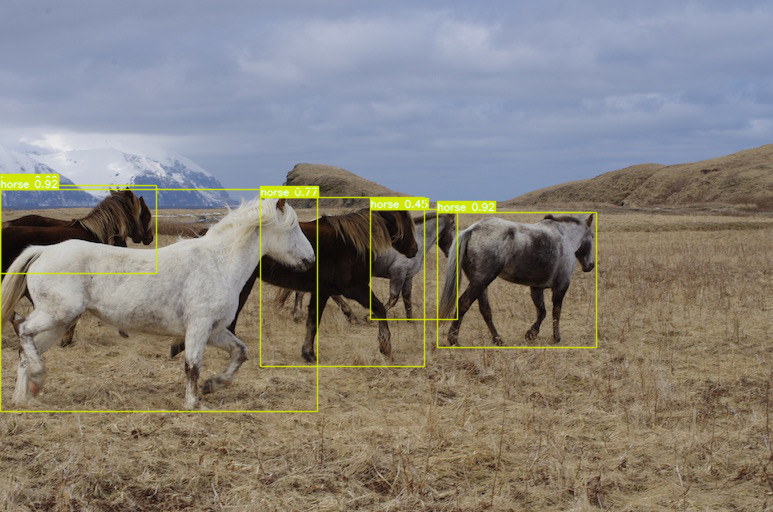

In [ ]:
Image.fromarray(image_with_boxes)
# the images do not fit the box hence we need make them fit according to the image size.
#the algorithm has recognized the object. here in this, we take an example of the image of horses.

In [ ]:
mp, mr, map50, map, maps, num_images, labels = test(data=data, model=compiled_model, dataloader=dataloader, names=NAMES)
# Print results
s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
print(s)
pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
print(pf % ('all', num_images, labels, mp, mr, map50, map))

  0%|          | 0/5000 [00:00<?, ?it/s]

               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        5000       36335       0.651       0.506       0.544       0.359


In [ ]:
!pip install nncf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.4/706.4 kB 46.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 17.6 MB/s eta 0:00:00
  Created wheel for pymoo: filename=pymoo-0.5.0-cp310-cp310-linux_x86_64.whl size=2679183 sha256=f79e35f589506056e5ca1c9413d0b039020dcb73d08f2da6e8f15d2d4814ab1a
  Stored in directory: /root/.cache/pip/wheels/bd/81/54/0ea5fd29acdfbbe43fe364b85c8a2d876a4aec07f34cf26dbc
Successfully built pymoo
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninsta

In [ ]:
import nncf  # noqa: F811


def transform_fn(data_item):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Tuple with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    img = data_item[0].numpy()
    input_tensor = prepare_input_tensor(img)
    return input_tensor


quantization_dataset = nncf.Dataset(dataloader, transform_fn)
quantized_model = nncf.quantize(model, quantization_dataset, preset=nncf.QuantizationPreset.MIXED)

serialize(quantized_model, 'model/yolov7-tiny_int8.xml')
int8_compiled_model = core.compile_model(quantized_model, "CPU")
boxes, image, input_shape = detect(int8_compiled_model, 'inference/images/horses.jpg')
image_with_boxes = draw_boxes(boxes[0], input_shape, image, NAMES, COLORS)
Image.fromarray(image_with_boxes)
int8_result = test(data=data, model=int8_compiled_model, dataloader=dataloader, names=NAMES)
mp, mr, map50, map, maps, num_images, labels = int8_result
# Print results
s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
print(s)
pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
print(pf % ('all', num_images, labels, mp, mr, map50, map))
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m model/yolov7-tiny.xml -d CPU -api async
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m model/yolov7-tiny_int8.xml -d CPU -api async

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


Biases correction: 100%|██████████| 58/58 [00:06<00:00,  9.40it/s]


  0%|          | 0/5000 [00:00<?, ?it/s]

               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        5000       36335        0.66       0.497       0.541       0.353
[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.1-11005-fa1c41994f3-releases/2023/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.0.1-11005-fa1c41994f3-releases/2023/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 28.34 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Mode

In [ ]:
boxes[0][2]

tensor([259.00000, 199.00000, 423.00000, 364.00000,   0.76884,  17.00000])

In [ ]:
boxes[0][4]

tensor([3.70000e+02, 2.10000e+02, 4.58000e+02, 3.19000e+02, 4.55647e-01, 1.70000e+01])

# FINDING CENTRE OF BOXES

In [ ]:
x1=[0]*len(boxes[0])
y1=[0]*len(boxes[0])
x2=[0]*len(boxes[0])
y2=[0]*len(boxes[0])
i=0


In [ ]:
for i in range(len(boxes[0])):
  x1[i] = boxes[0][i][0]
  y1[i] = boxes[0][i][1]
  x2[i] = boxes[0][i][2]
  y2[i] = boxes[0][i][3]

In [ ]:
centrex = [0]*len(boxes[0])
centrey = [0]*len(boxes[0])
i=0
for i in range(len(boxes[0])):
  centrex[i] = (x1[i]+x2[i])/2
  centrey[i] = (y1[i]+y2[i])/2

In [ ]:
print(centrex)
print(centrey)

[tensor(516.50000), tensor(157.50000), tensor(341.), tensor(78.50000), tensor(414.)]
[tensor(279.50000), tensor(300.50000), tensor(281.50000), tensor(230.50000), tensor(264.50000)]


In [ ]:
print(centrex[0]-centrex[2])
print(centrey[0]-centrey[2])
min_distance = ((centrex[0]-centrex[2])**2+(centrey[0]-centrey[2])**2)**0.5


tensor(175.50000)
tensor(-2.)


In [ ]:
min_distance

tensor(175.51140)

In [ ]:
dist=[]
for i in range(len(centrex)):
  for j in range(i,len(centrex)):
    temp = (((centrex[i]-centrex[j])**2+(centrey[i]-centrey[j])**2)**0.5)
    if temp != 0:
      dist.append([((centrex[i]-centrex[j])**2+(centrey[i]-centrey[j])**2)**0.5,boxes[0][i][4],boxes[0][j][4],centrex[i],centrey[i],centrex[j],centrey[j]])

In [ ]:
dist

[[tensor(359.61368),
  tensor(0.92510),
  tensor(0.91547),
  tensor(516.50000),
  tensor(279.50000),
  tensor(157.50000),
  tensor(300.50000)],
 [tensor(175.51140),
  tensor(0.92510),
  tensor(0.76884),
  tensor(516.50000),
  tensor(279.50000),
  tensor(341.),
  tensor(281.50000)],
 [tensor(440.73233),
  tensor(0.92510),
  tensor(0.68274),
  tensor(516.50000),
  tensor(279.50000),
  tensor(78.50000),
  tensor(230.50000)],
 [tensor(103.59174),
  tensor(0.92510),
  tensor(0.45565),
  tensor(516.50000),
  tensor(279.50000),
  tensor(414.),
  tensor(264.50000)],
 [tensor(184.48103),
  tensor(0.91547),
  tensor(0.76884),
  tensor(157.50000),
  tensor(300.50000),
  tensor(341.),
  tensor(281.50000)],
 [tensor(105.55093),
  tensor(0.91547),
  tensor(0.68274),
  tensor(157.50000),
  tensor(300.50000),
  tensor(78.50000),
  tensor(230.50000)],
 [tensor(259.01401),
  tensor(0.91547),
  tensor(0.45565),
  tensor(157.50000),
  tensor(300.50000),
  tensor(414.),
  tensor(264.50000)],
 [tensor(267.4

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
def DrawLineRed(x1,y1,x2,y2,img):
  start_point = (x1, y1)
  end_point = (x2, y2)
  color = (255, 0, 0)
  thickness = 1
  return cv2.line(img, start_point, end_point, color, thickness)
def DrawLineGreen(x1,y1,x2,y2,img):
  start_point = (x1, y1)
  end_point = (x2, y2)
  color = (0, 255, 0)
  thickness = 1
  return cv2.line(img, start_point, end_point, color, thickness)

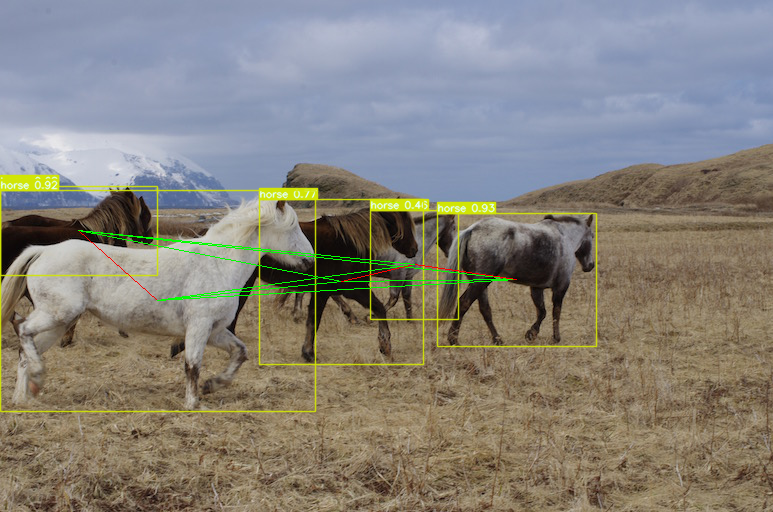

In [ ]:
import cv2
path = r'inference/images/horses.jpg'
img = image_with_boxes
for ele in dist:
  img=DrawLineGreen(int(ele[3].numpy()),int(ele[4].numpy()),int(ele[5].numpy()),int(ele[6].numpy()),img)
  if ele[0] < min_distance:
    #print(int(ele[3].numpy()),int(ele[4].numpy()),int(ele[5].numpy()),int(ele[6].numpy()))
    img=DrawLineRed(int(ele[3].numpy()),int(ele[4].numpy()),int(ele[5].numpy()),int(ele[6].numpy()),img)
    #x1,y1,x2,y2,confidence of first,confidence of second
Image.fromarray(img)

here the green lines represent appropriate distance while the red ones tell us that the objects are not enough far apart

In [ ]:
float(dist[0][0].numpy())

359.6136779785156

In [ ]:
input_shape

(1, 3, 640, 640)

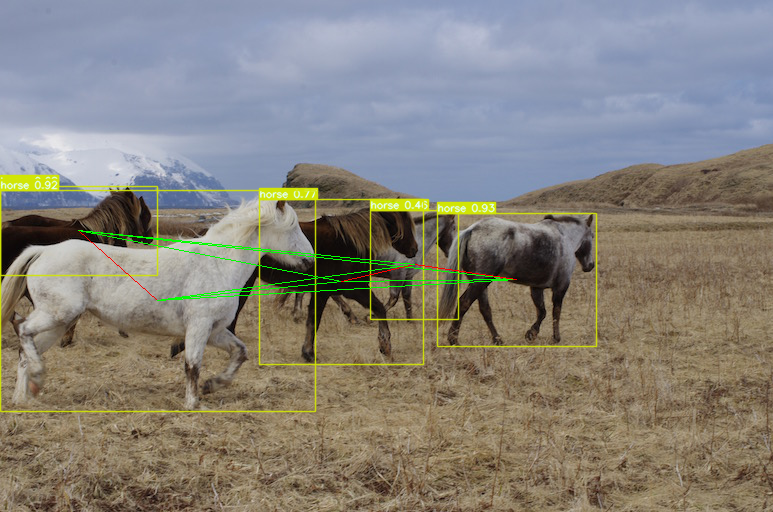

In [ ]:
Image.fromarray(image_with_boxes)
#final result for this img.